In [1]:
import pandas as pd
import numpy as np
from astroquery.gaia import Gaia
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [5]:
# For getting Gaia Data from NASA Archive through TIC #
# DONT RUN UNLESS YOU NEED THE DATA

import pandas as pd
from astroquery.simbad import Simbad
from astroquery.gaia import Gaia
from astropy.table import Table

def get_gaia_source_id(tic_id):
    try:
        custom_simbad = Simbad()
        custom_simbad.add_votable_fields('ids')
        result = custom_simbad.query_object(f"TIC {tic_id}")
        if result is not None:
            ids = result['IDS'][0]
            for id in ids.split('|'):
                if 'Gaia DR3' in id:
                    return id.split(' ')[-1]
                elif 'Gaia DR2' in id:
                    return id.split(' ')[-1]
                elif 'Gaia DR1' in id:
                    return id.split(' ')[-1]
    except Exception as e:
        print(f"Warning: {e} for TIC {tic_id}")
    return None

def query_gaia_data(source_id):
    query = f"""
    SELECT source_id AS SOURCE_ID, parallax, pmra, pmdec, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, radial_velocity, 
    astrometric_excess_noise, astrometric_excess_noise_sig, ra, ra_error, dec, dec_error, parallax_error, 
    parallax_over_error, pmra_error, pmdec_error, astrometric_n_obs_al, astrometric_n_obs_ac, 
    astrometric_n_good_obs_al, astrometric_n_bad_obs_al, astrometric_gof_al, astrometric_chi2_al, 
    nu_eff_used_in_astrometry, astrometric_matched_transits, visibility_periods_used, 
    astrometric_sigma5d_max, ruwe, phot_g_mean_flux, phot_g_mean_flux_error, phot_g_mean_flux_over_error, 
    phot_bp_mean_flux, phot_bp_mean_flux_error, phot_bp_mean_flux_over_error, phot_rp_mean_flux, 
    phot_rp_mean_flux_error, phot_rp_mean_flux_over_error, radial_velocity_error, rv_method_used, 
    rv_nb_transits, rv_nb_deblended_transits, rv_visibility_periods_used, rv_expected_sig_to_noise, 
    rv_renormalised_gof, rv_chisq_pvalue, rv_time_duration, rv_amplitude_robust, rv_template_teff, 
    rv_template_logg, rv_template_fe_h, vbroad, vbroad_error, vbroad_nb_transits, grvs_mag, 
    grvs_mag_error, grvs_mag_nb_transits, rvs_spec_sig_to_noise
    FROM gaiadr3.gaia_source
    WHERE source_id = {source_id}
    """
    job = Gaia.launch_job(query)
    results = job.get_results()
    return results


csv_file = 'TOI_2024.08.03_15.56.31.csv'
df = pd.read_csv(csv_file)

gaia_data = []

for tic_id in df['tid']:
    gaia_source_id = get_gaia_source_id(tic_id)
    if gaia_source_id:
        gaia_data.append(query_gaia_data(gaia_source_id))

if gaia_data:
    gaia_df = pd.concat([table.to_pandas() for table in gaia_data], ignore_index=True)
    output_csv = 'gaia_data_results.csv'
    gaia_df.to_csv(output_csv, index=False)
    print(f"GAIA data has been saved to {output_csv}")
else:
    print("No GAIA data found.")

GAIA data has been saved to gaia_data_results.csv


In [2]:
# Load the CSV file
file_path = 'PS_2024.07.13_00.00.28.csv'
nasa_exoplanets_data = pd.read_csv(file_path, on_bad_lines='skip')
nasa_exoplanets_data['gaia_id_number'] = nasa_exoplanets_data['gaia_id'].str.extract(r'Gaia DR2 (\d+)')
nasa_exoplanets_data = nasa_exoplanets_data.dropna(subset=['gaia_id_number'])
nasa_exoplanets_data['gaia_id_number'] = nasa_exoplanets_data['gaia_id_number'].astype(str)
gaia_source_ids = nasa_exoplanets_data['gaia_id_number'].unique()

query = f"""
SELECT source_id AS SOURCE_ID, parallax, pmra, pmdec, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, radial_velocity, 
astrometric_excess_noise, astrometric_excess_noise_sig, ra, ra_error, dec, dec_error, parallax_error, 
parallax_over_error, pmra_error, pmdec_error, astrometric_n_obs_al, astrometric_n_obs_ac, 
astrometric_n_good_obs_al, astrometric_n_bad_obs_al, astrometric_gof_al, astrometric_chi2_al, 
nu_eff_used_in_astrometry, astrometric_matched_transits, visibility_periods_used, 
astrometric_sigma5d_max, ruwe, phot_g_mean_flux, phot_g_mean_flux_error, phot_g_mean_flux_over_error, 
phot_bp_mean_flux, phot_bp_mean_flux_error, phot_bp_mean_flux_over_error, phot_rp_mean_flux, 
phot_rp_mean_flux_error, phot_rp_mean_flux_over_error, radial_velocity_error, rv_method_used, 
rv_nb_transits, rv_nb_deblended_transits, rv_visibility_periods_used, rv_expected_sig_to_noise, 
rv_renormalised_gof, rv_chisq_pvalue, rv_time_duration, rv_amplitude_robust, rv_template_teff, 
rv_template_logg, rv_template_fe_h, vbroad, vbroad_error, vbroad_nb_transits, grvs_mag, 
grvs_mag_error, grvs_mag_nb_transits, rvs_spec_sig_to_noise
FROM gaiadr3.gaia_source
WHERE source_id IN ({','.join(f"'{source_id}'" for source_id in gaia_source_ids)})
"""

job = Gaia.launch_job_async(query)
result = job.get_results()

print(result)
result.write('gaia_query_results.csv', format='csv', overwrite=True)

INFO: Query finished. [astroquery.utils.tap.core]
     SOURCE_ID           parallax      ... rvs_spec_sig_to_noise
                           mas         ...                      
------------------- ------------------ ... ---------------------
   3179036008830848 116.26781443397161 ...                    --
  24570756281835392  8.453916990456412 ...                    --
  35227046884571776 260.98844068047276 ...                    --
  43802039287826432  21.47188045529033 ...                    --
  47316005432912256  8.223586002351029 ...                    --
  53006669599267328  5.035355572432337 ...              75.52384
  60684353135617792 19.917528146078535 ...                    --
  76868614540049408 223.73208720990553 ...             99.641556
  95652018353917056 30.153469786700956 ...                    --
  96530596864007552 0.8331223811176302 ...                    --
                ...                ... ...                   ...
6770721346051487872  9.515695218944568 .

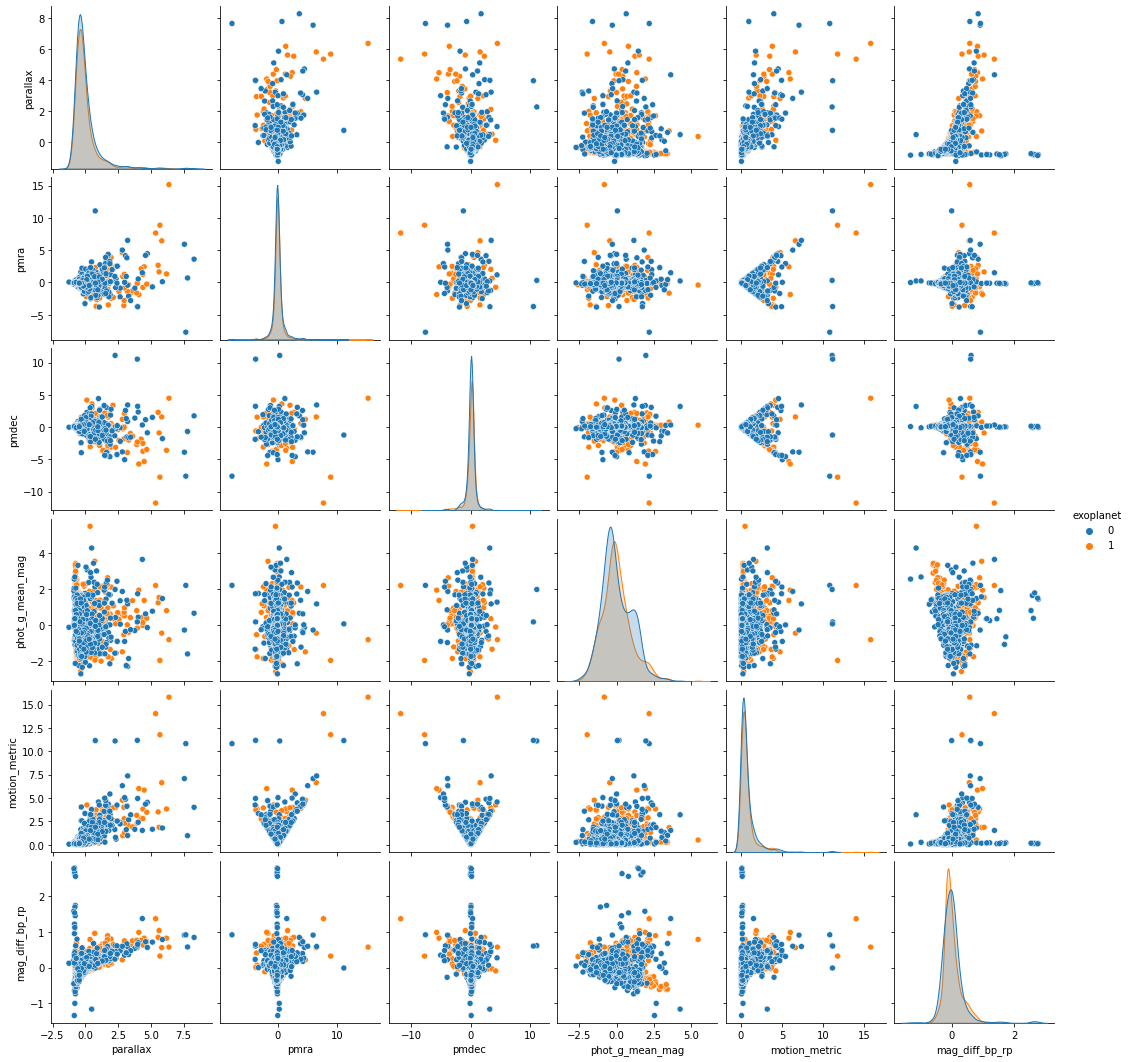

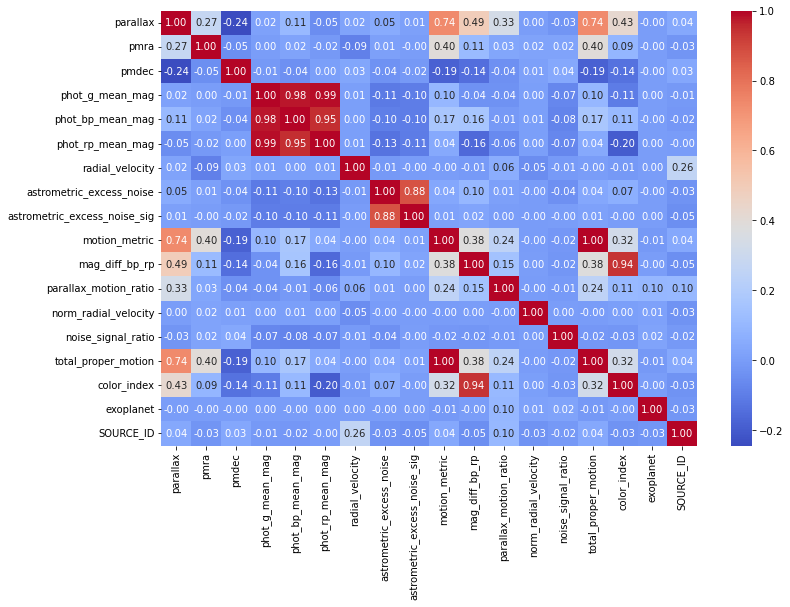

Target distribution before SMOTE: 0    843
1    730
Name: exoplanet, dtype: int64
Target distribution after SMOTE: (array([0, 1], dtype=int64), array([843, 843], dtype=int64))
Shape of X_balanced: (1686, 16)
Shape of y_balanced: (1686,)
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Cross-validated ROC AUC scores: [0.98567587 0.99544357 0.99560826 0.99756691 0.99386198]
Mean ROC AUC score: 0.9936313156982453
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       156
           1       1.00      0.92      0.96       182

    accuracy                           0.96       338
   macro avg       0.96      0.96      0.96       338
weighted avg       0.96      0.96      0.96       338

ROC AUC Score on test set: 0.9986615948154409
Feature importances:
 astrometric_excess_noise_sig    0.466537
astrometric_excess_noise        0.304089
noise_signal_ratio              0.121250
phot_rp_mean_mag                0.017358
phot_g_mean_mag

In [3]:
# Machine Learning Model Using False Positives

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocess GAIA data
def preprocess_data(df):
    SOURCE_IDs = df['SOURCE_ID']
    df = df.drop('SOURCE_ID', axis=1)
    
    imputer = SimpleImputer(strategy='median')
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_imputed), columns=df.columns)
    
    df_scaled['SOURCE_ID'] = SOURCE_IDs.values
    return df_scaled

confirmed_planets_data = pd.read_csv('gaia_query_results.csv')
confirmed_data = preprocess_data(confirmed_planets_data)
confirmed_data['exoplanet'] = 1

false_positives_data = pd.read_csv('gaia_data_results.csv')
false_positives_data = preprocess_data(false_positives_data)
false_positives_data['exoplanet'] = 0
combined_data = pd.concat([confirmed_data, false_positives_data], ignore_index=True)

# Feature engineering
def feature_engineering(df):
    df['motion_metric'] = np.sqrt(df['pmra']**2 + df['pmdec']**2)
    df['mag_diff_bp_rp'] = df['phot_bp_mean_mag'] - df['phot_rp_mean_mag']
    df['parallax_motion_ratio'] = df['parallax'] / df['motion_metric']
    df['norm_radial_velocity'] = df['radial_velocity'] / df['parallax']
    df['noise_signal_ratio'] = df['astrometric_excess_noise'] / df['astrometric_excess_noise_sig']
    df['total_proper_motion'] = np.sqrt(df['pmra']**2 + df['pmdec']**2)
    df['color_index'] = df['phot_bp_mean_mag'] - df['phot_g_mean_mag']
    return df

combined_data = feature_engineering(combined_data)

model_columns = [
    'parallax', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'radial_velocity', 
    'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'motion_metric', 'mag_diff_bp_rp', 
    'parallax_motion_ratio', 'norm_radial_velocity', 'noise_signal_ratio', 'total_proper_motion', 'color_index'
]
combined_data = combined_data[model_columns + ['exoplanet', 'SOURCE_ID']]

# Perform EDA on combined data before splitting
def perform_eda(df):
    sns.pairplot(df[['parallax', 'pmra', 'pmdec', 'phot_g_mean_mag', 'motion_metric', 'mag_diff_bp_rp', 'exoplanet']], hue='exoplanet')
    plt.show()

    corr_matrix = df.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.show()

perform_eda(combined_data)

X = combined_data.drop(['exoplanet', 'SOURCE_ID'], axis=1)
y = combined_data['exoplanet']

print("Target distribution before SMOTE:", y.value_counts())

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)
print("Target distribution after SMOTE:", np.unique(y_balanced, return_counts=True))

print("Shape of X_balanced:", X_balanced.shape)
print("Shape of y_balanced:", y_balanced.shape)

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [5000, 6000], # Number of trees in the forest. Increasing this value can improve model performance by reducing variance, but it also increases computational cost.
    'max_depth': [5, 10], # Making trees shallower
    'min_samples_split': [10, 15], # Requiring more samples to split
    'min_samples_leaf': [80, 100] # Requiring more samples at leaf
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='roc_auc')
print("Cross-validated ROC AUC scores:", cv_scores)
print("Mean ROC AUC score:", np.mean(cv_scores))

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC Score on test set:", roc_auc_score(y_test, y_pred_proba))

feature_importances = pd.Series(best_model.feature_importances_, index=X.columns)
print("Feature importances:\n", feature_importances.sort_values(ascending=False))

X_full = combined_data[model_columns]

combined_data['probability'] = best_model.predict_proba(X_full)[:, 1]

# Sort by the highest probabilities and select the top 10 candidates
# top_candidates = combined_data[combined_data['exoplanet'] == 1].nlargest(10, 'probability')
top_candidates = combined_data.nlargest(10, 'probability')

print("Top 10 Exoplanet Candidates:")
print(top_candidates[['SOURCE_ID', 'probability']])

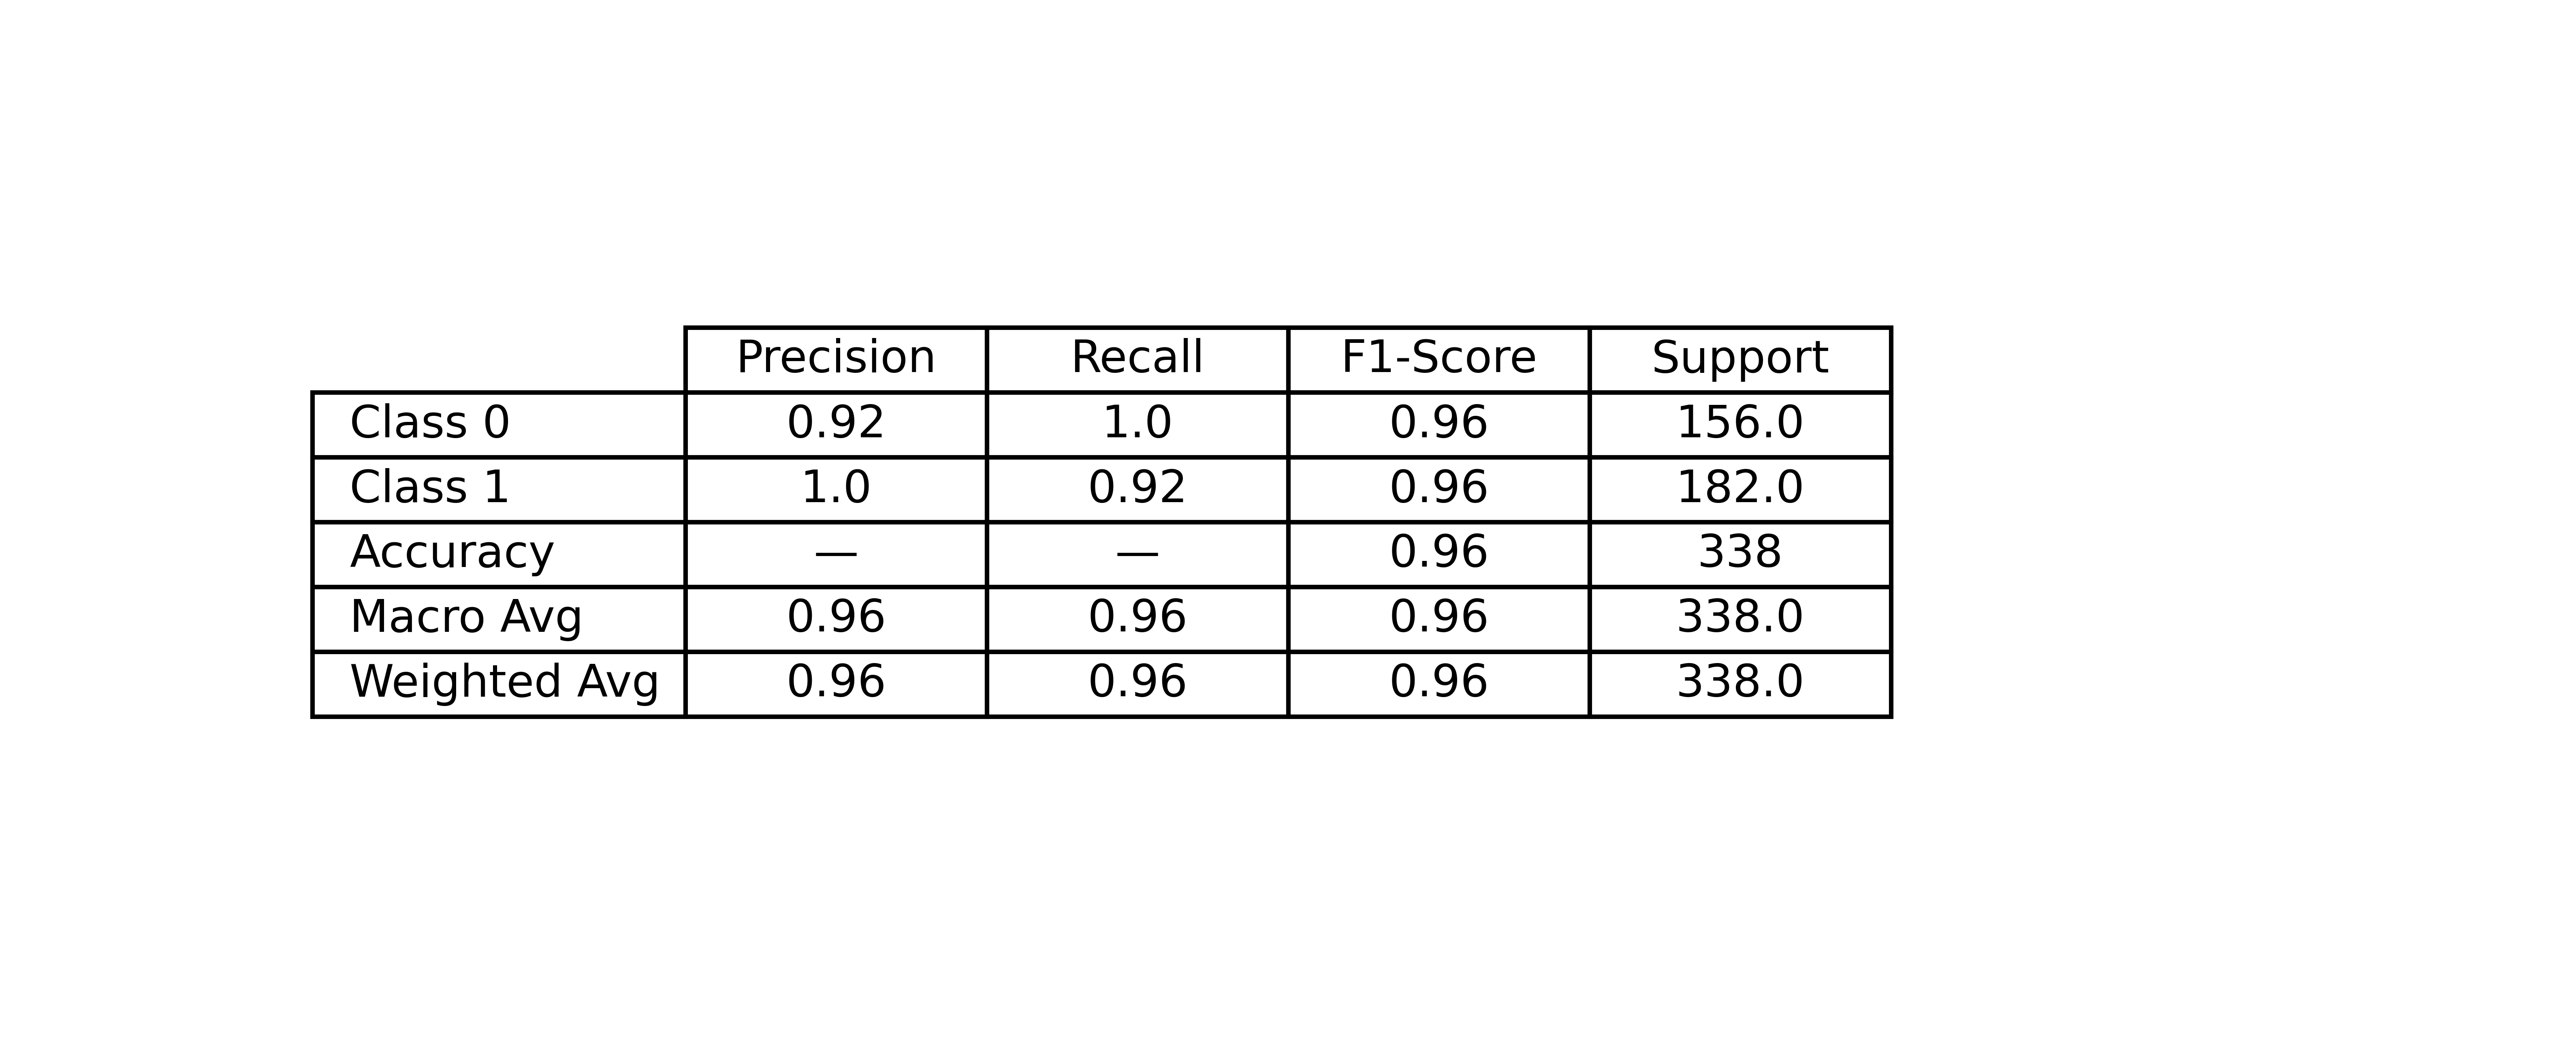

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table

# Define the data from the classification report
data = {
    'Class 0': {'Precision': 0.92, 'Recall': 1.00, 'F1-Score': 0.96, 'Support': 156},
    'Class 1': {'Precision': 1.00, 'Recall': 0.92, 'F1-Score': 0.96, 'Support': 182},
    'Accuracy': {'Precision': '—', 'Recall': '—', 'F1-Score': 0.96, 'Support': 338},
    'Macro Avg': {'Precision': 0.96, 'Recall': 0.96, 'F1-Score': 0.96, 'Support': 338},
    'Weighted Avg': {'Precision': 0.96, 'Recall': 0.96, 'F1-Score': 0.96, 'Support': 338}
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# Ensure 'Support' is displayed as an integer
df.loc['Support'] = df.loc['Support'].astype(int)

# Transpose the DataFrame for better readability
df = df.T

# Plot the table
fig, ax = plt.subplots(figsize=(10, 4), dpi=800)  # Set the figure size
ax.axis('off')  # Hide the axis
tbl = table(ax, df, loc='center', cellLoc='center', colWidths=[0.1]*len(df.columns))  # Create the table

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2)  # Scale the table

plt.show()

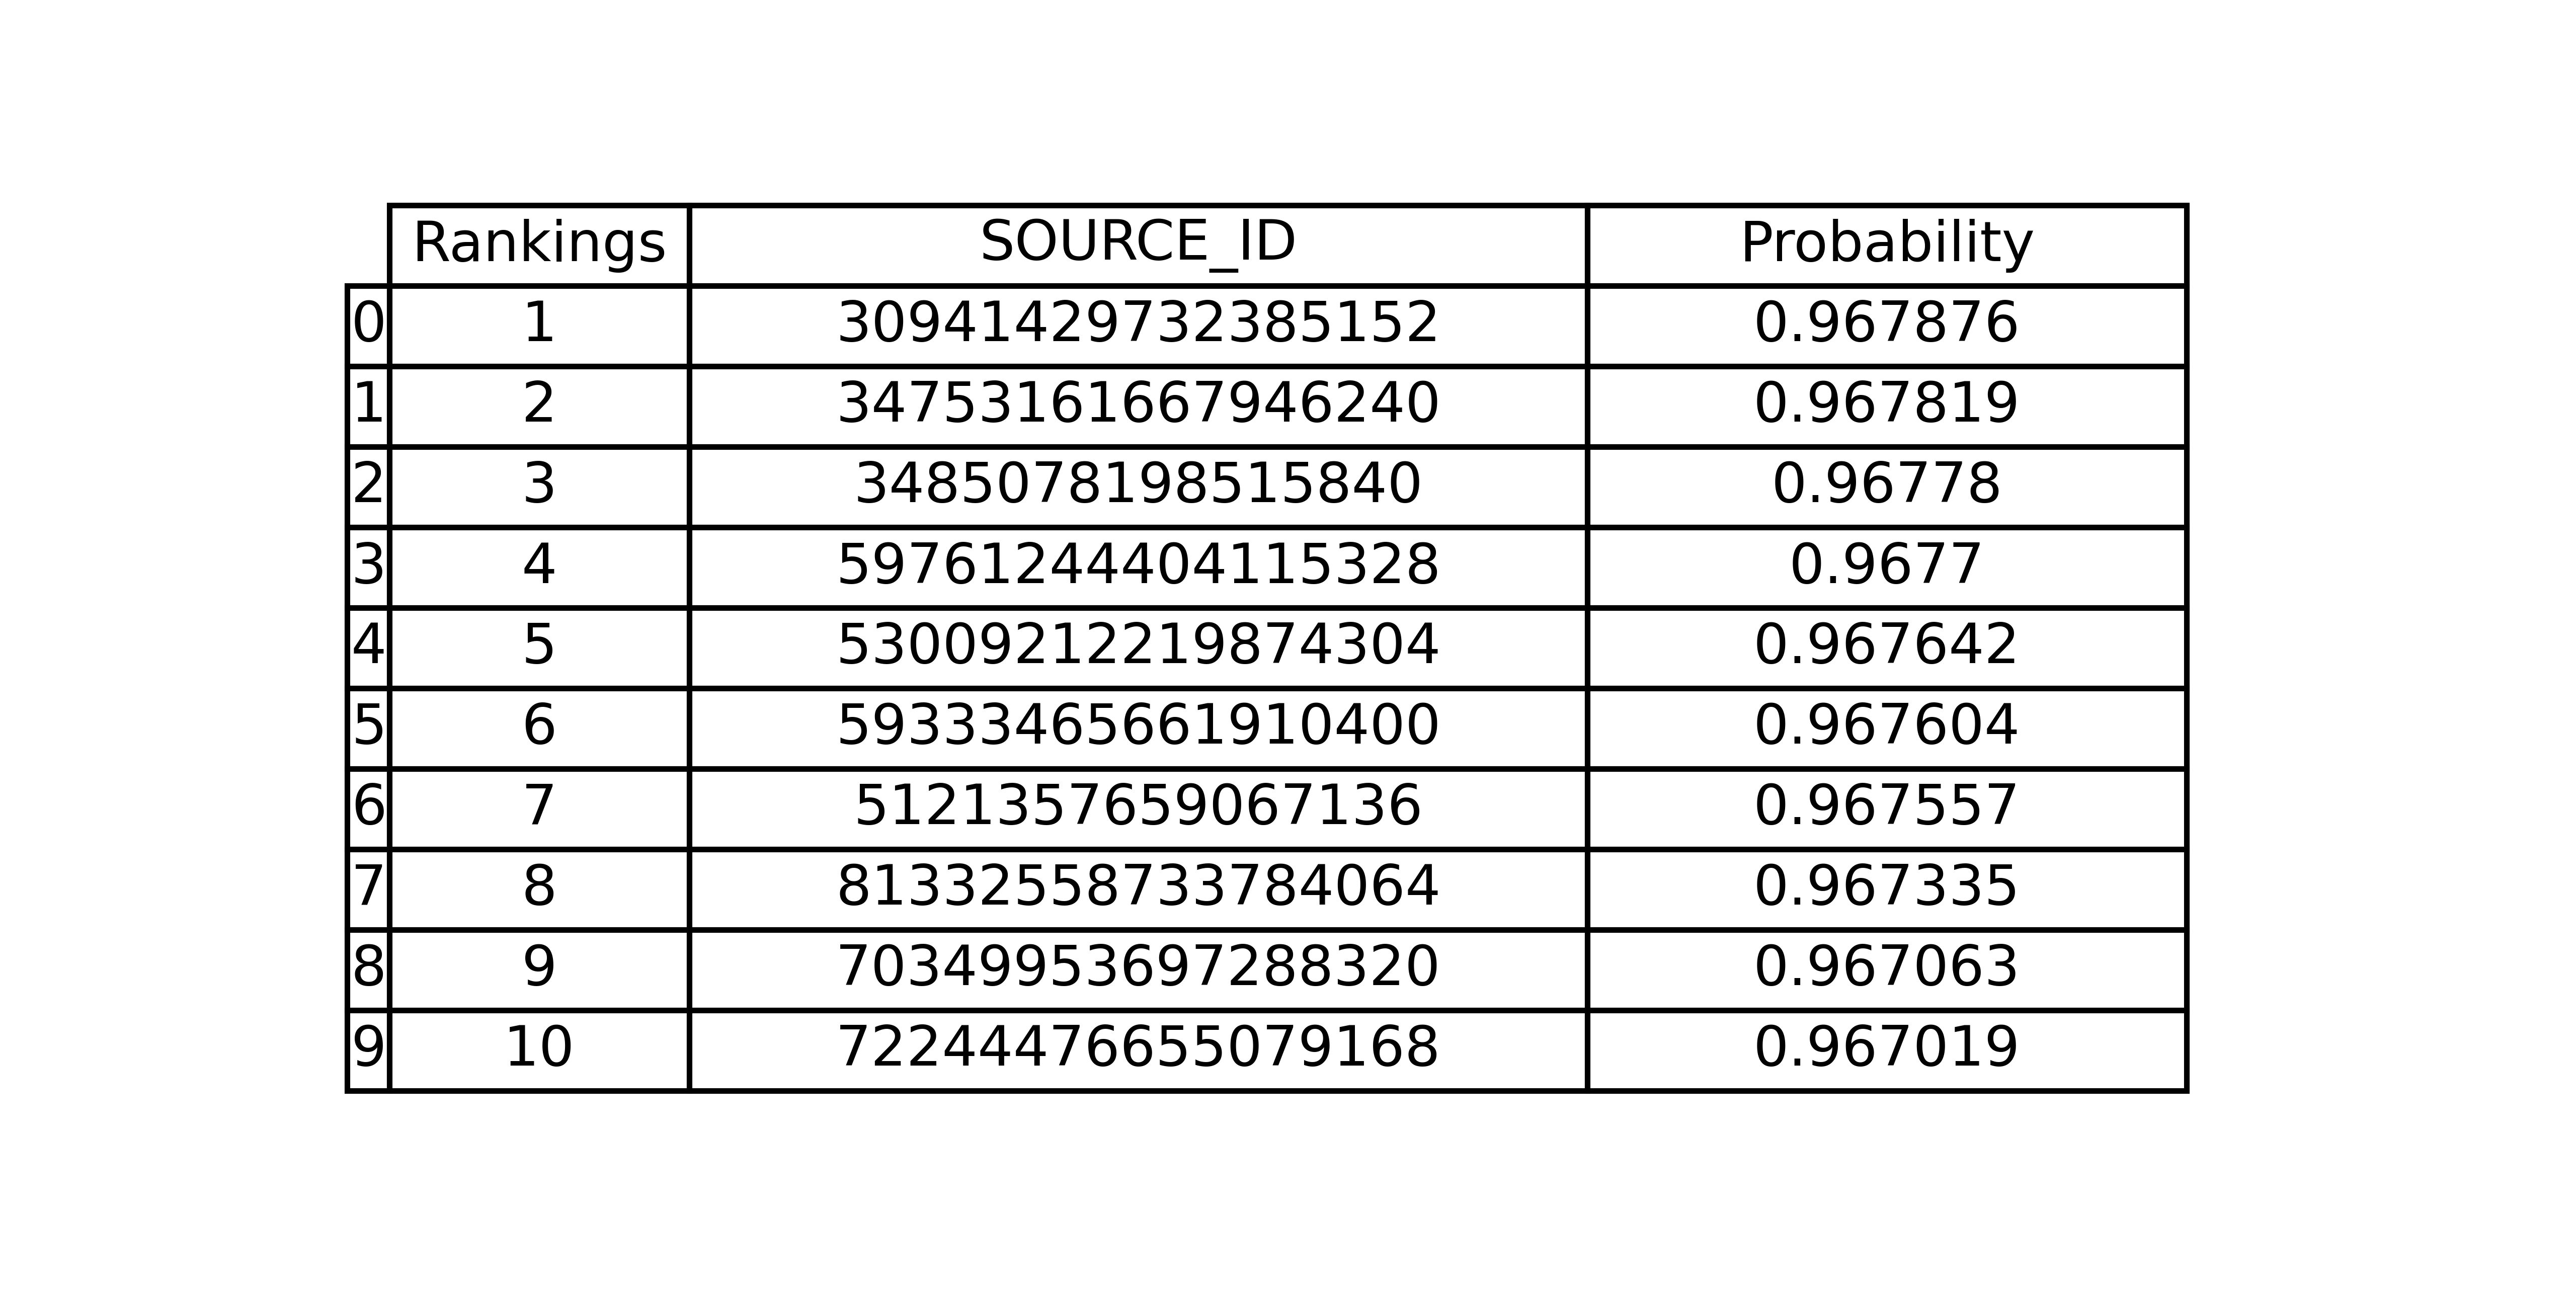

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table

# Define the data for the table
data = {
    'Rankings': range(1, 11),
    'SOURCE_ID': [
        30941429732385152,
        34753161667946240,
        3485078198515840,
        59761244404115328,
        53009212219874304,
        59333465661910400,
        5121357659067136,
        81332558733784064,
        70349953697288320,
        72244476655079168
    ],
    'Probability': [
        0.967876,
        0.967819,
        0.967780,
        0.967700,
        0.967642,
        0.967604,
        0.967557,
        0.967335,
        0.967063,
        0.967019
    ]
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# Convert SOURCE_ID to string to prevent scientific notation
df['SOURCE_ID'] = df['SOURCE_ID'].astype(str)

# Plot the table with the index included
fig, ax = plt.subplots(figsize=(8, 4), dpi=800)  # Set the figure size
ax.axis('off')  # Hide the axis
tbl = table(ax, df, loc='center', cellLoc='center', colWidths=[0.1, 0.3, 0.2])  # Create the table

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2)  # Scale the table

plt.show()

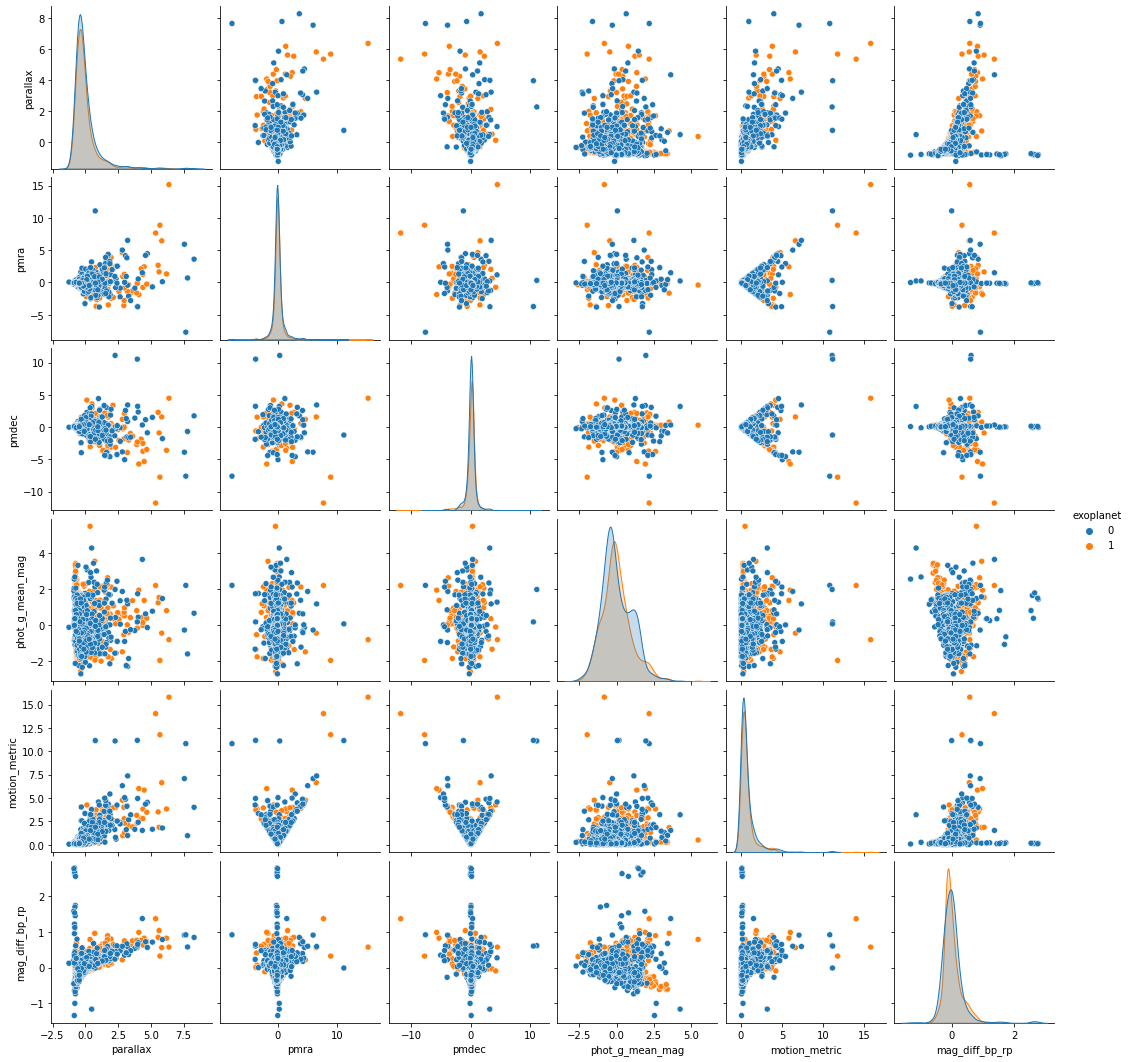

In [9]:
def perform_eda(df):
    # Pairplot for initial visualization
    sns.pairplot(df[['parallax', 'pmra', 'pmdec', 'phot_g_mean_mag', 'motion_metric', 'mag_diff_bp_rp', 'exoplanet']], hue='exoplanet')
    plt.show()

    # Check for correlations
    corr_matrix = df.corr()
    
    # Filter correlations to only include those between 0.1 and 0.85 (or -0.1 and -0.85)
    mask = ((corr_matrix >= 0.1) & (corr_matrix <= 0.85)) | ((corr_matrix <= -0.1) & (corr_matrix >= -0.85))
    
    # Identify the rows and columns to keep based on the mask
    rows_and_columns_to_keep = mask.any(axis=0) | mask.any(axis=1)
    
    # Filter the original correlation matrix to include only the relevant rows and columns
    filtered_corr_matrix = corr_matrix.loc[rows_and_columns_to_keep, rows_and_columns_to_keep]
    
    plt.figure(figsize=(12, 8), dpi=800)
    sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
#     plt.savefig('heatmap_8k_false_positives_cut.jpeg', dpi=800, quality=95, format='jpeg')
    plt.show()

perform_eda(combined_data)

<IPython.core.display.Javascript object>


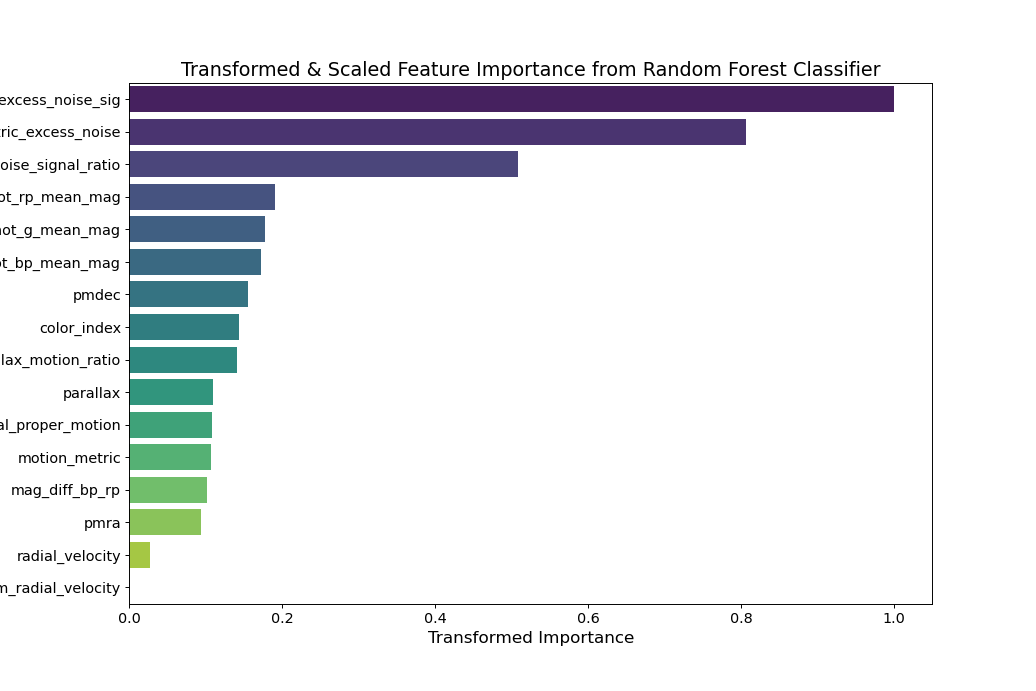

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Assuming feature_importances contains the importance values from the Random Forest model
# Convert the feature importances into a Pandas DataFrame for easy plotting
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,  # Assuming X is your features DataFrame
    'Importance': best_model.feature_importances_
})

# Normalize the feature importances using MinMaxScaler
scaler = MinMaxScaler()
feature_importance_df['Scaled Importance'] = scaler.fit_transform(feature_importance_df[['Importance']])

# Apply a power transformation to reduce the gap between low and high values
feature_importance_df['Transformed Importance'] = feature_importance_df['Scaled Importance'] ** 0.5  # Square root transformation

# Sort the DataFrame by the transformed importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Transformed Importance', ascending=False)

# Plot the transformed feature importance using seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='Transformed Importance', y='Feature', data=feature_importance_df, palette='viridis')

# Add a title and labels to make the plot more informative
plt.title('Transformed & Scaled Feature Importance from Random Forest Classifier', fontsize=16)
plt.xlabel('Transformed Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)

# Increase the font size of the tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save the plot as a high-resolution image
plt.savefig("transformed_feature_importance_barplot.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


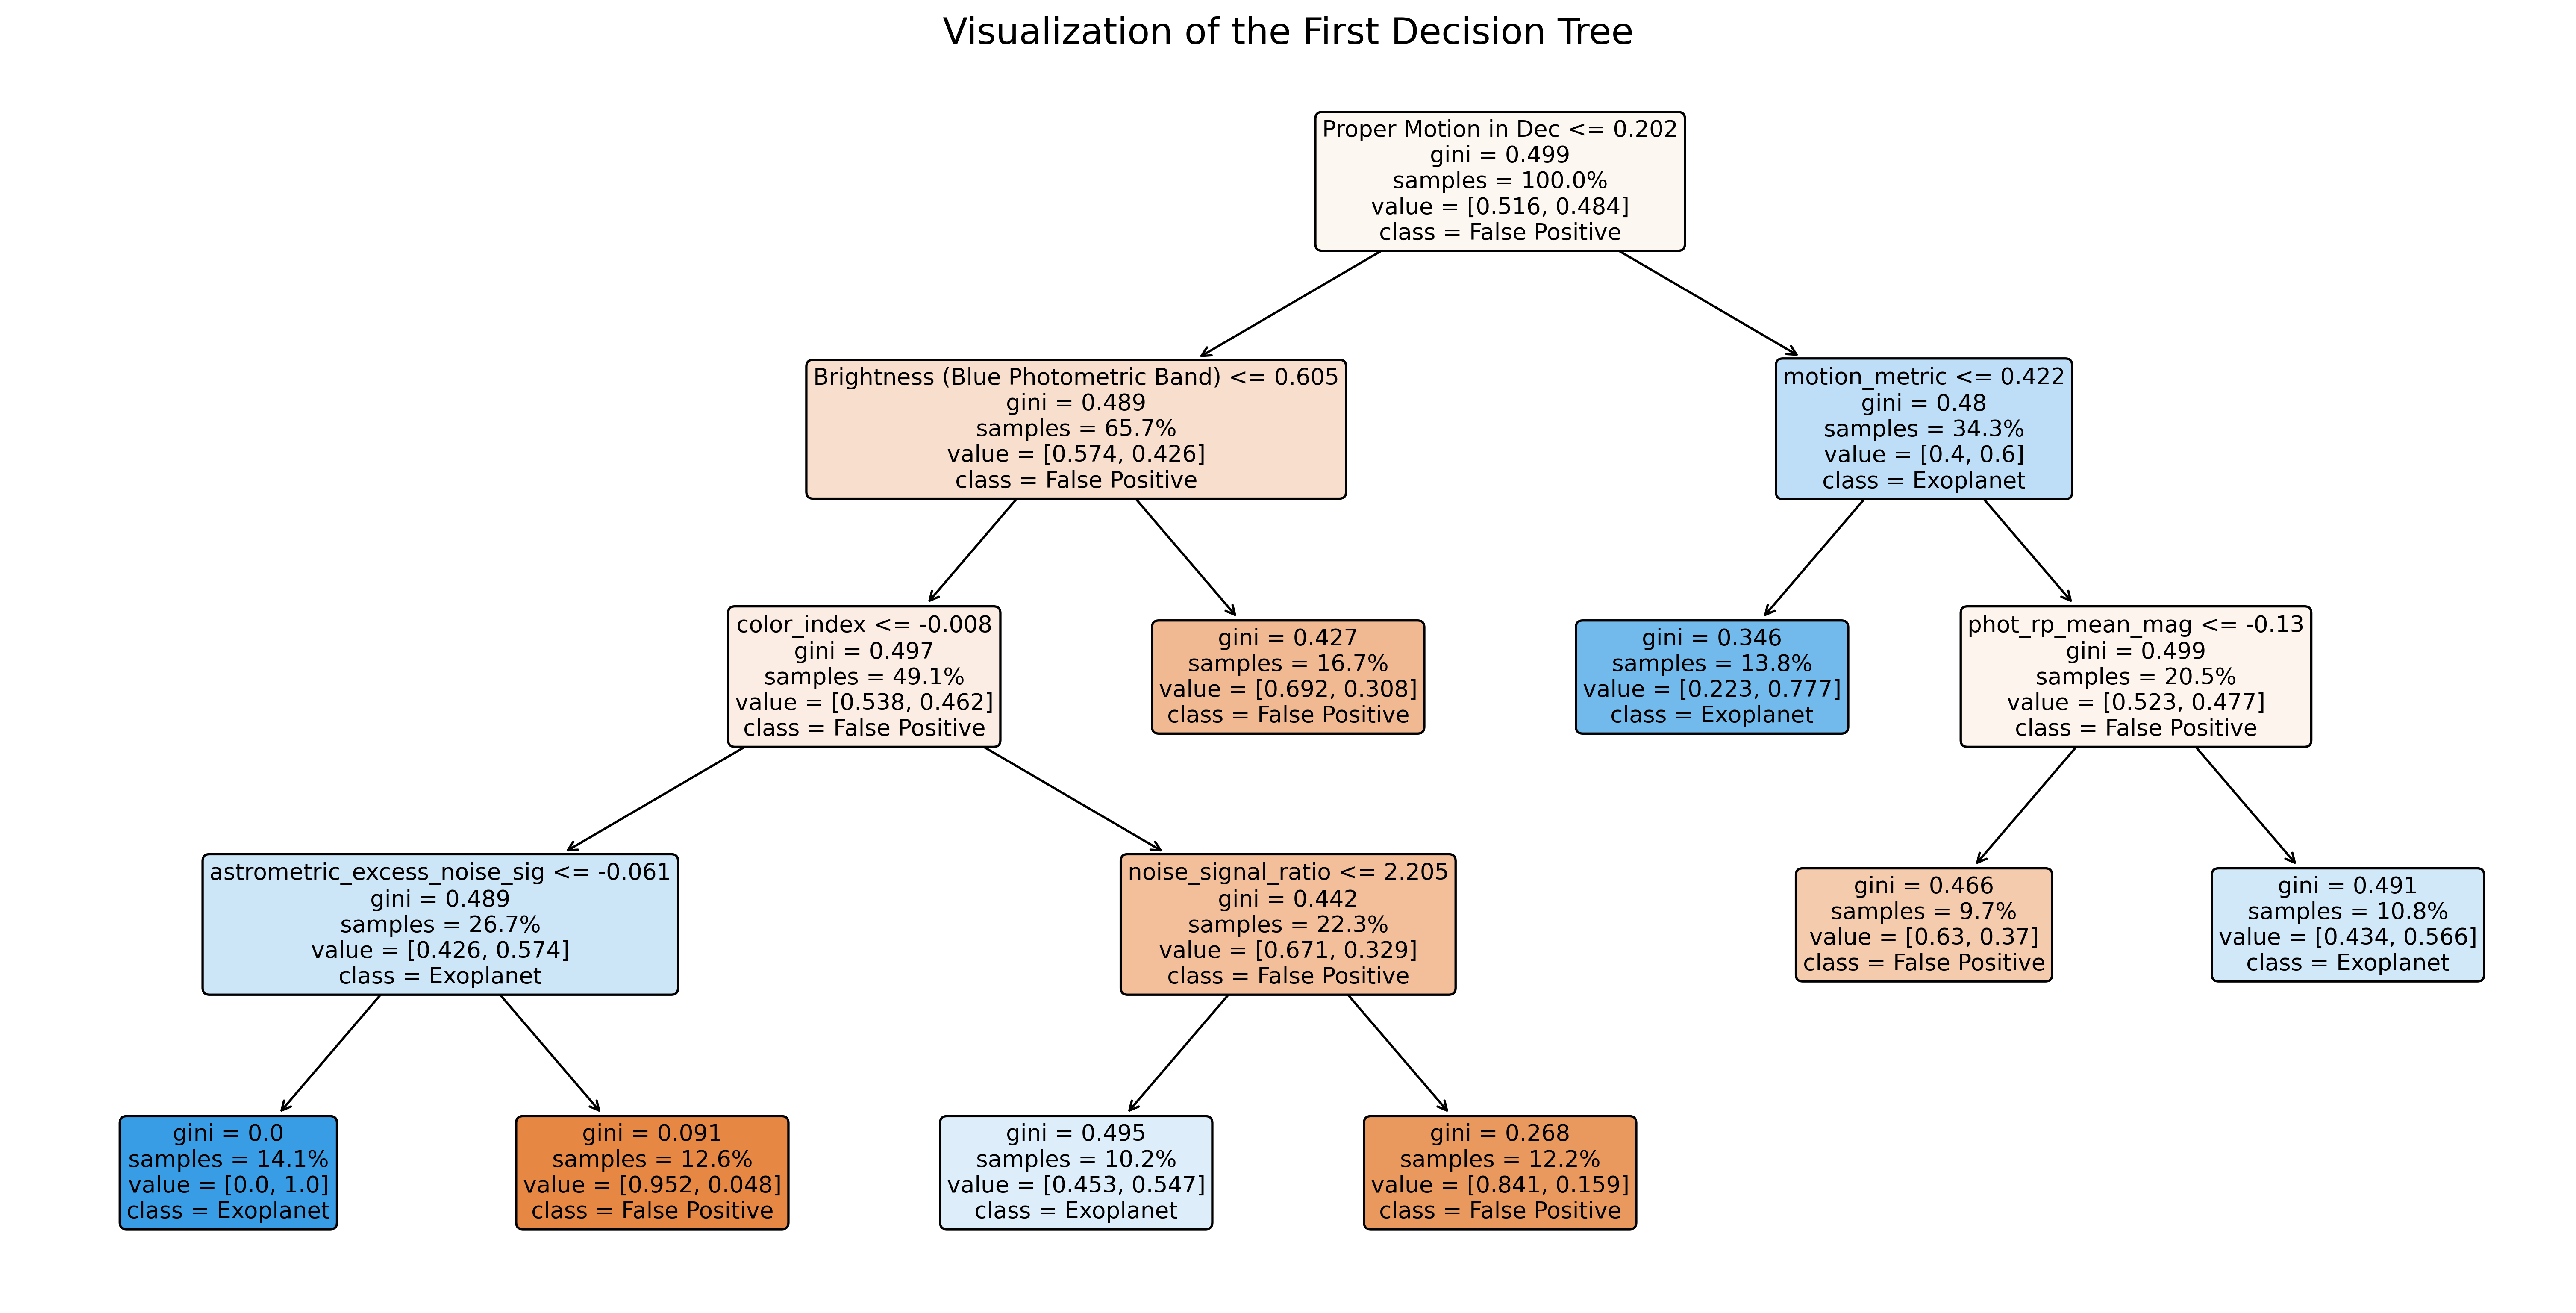

In [62]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
%matplotlib inline


# Create a mapping of feature names to more understandable terms
feature_name_map = {
    'pmdec': 'Proper Motion in Dec',
    'phot_bp_mean_mag': 'Brightness (Blue Photometric Band)',
    'astrometric_excess_noise': 'Astrometric Noise',
    # Add more mappings if needed
}

# Create a mapping of class names for better understanding
class_name_map = {
    0: 'False Positive',
    1: 'Exoplanet'
}

# Function to plot the decision tree with simplified labels
def plot_simplified_tree(tree, feature_map, class_map):
    # Use the feature names and class names in the plot
    plt.figure(figsize=(20, 10), dpi=384)
    plot_tree(tree, 
              filled=True, 
              feature_names=[feature_map.get(f, f) for f in X.columns],  # Map feature names
              class_names=[class_map[0], class_map[1]],  # Map class names
              rounded=True, 
              fontsize=10, 
              proportion=True)
    plt.title("Visualization of the First Decision Tree", fontsize=16)
    plt.savefig("simplified_first_tree_visualization.png", dpi=300, format='png')

# Plot the tree with simplified labels
plot_simplified_tree(first_tree, feature_name_map, class_name_map)


In [3]:
import seaborn as sns

# Save pairplot as an 8K JPEG with the same scale
pairplot_fig = sns.pairplot(combined_data[['parallax', 'pmra', 'pmdec', 'phot_g_mean_mag', 'motion_metric', 'mag_diff_bp_rp', 'exoplanet']], hue='exoplanet')
pairplot_fig.fig.tight_layout(pad=2.0)  # Adjust padding
# pairplot_fig.savefig('pairplot_8k_false_positives.jpeg', dpi=800, quality=95, format='jpeg')
plt.close()

# Save heatmap as an 8K JPEG with the same scale
corr_matrix = combined_data.corr()
heatmap_fig, ax = plt.subplots(figsize=(12, 8))  # Keep the same figure size
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', ax=ax)
heatmap_fig.tight_layout(pad=2.0)  # Adjust padding
# heatmap_fig.savefig('heatmap_8k_false_positives.jpeg', dpi=800, quality=95, format='jpeg')
plt.close()

NameError: name 'combined_data' is not defined

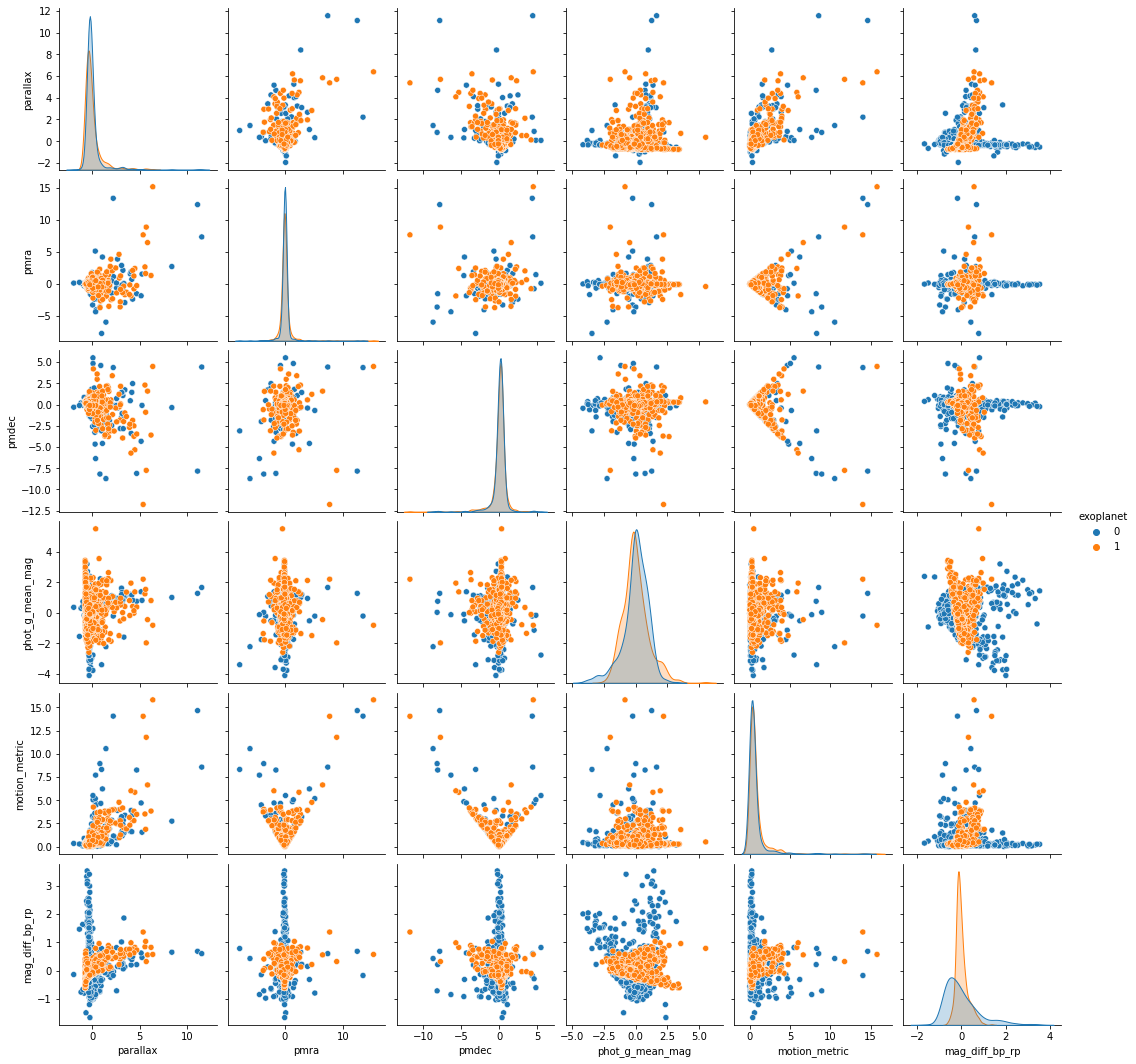

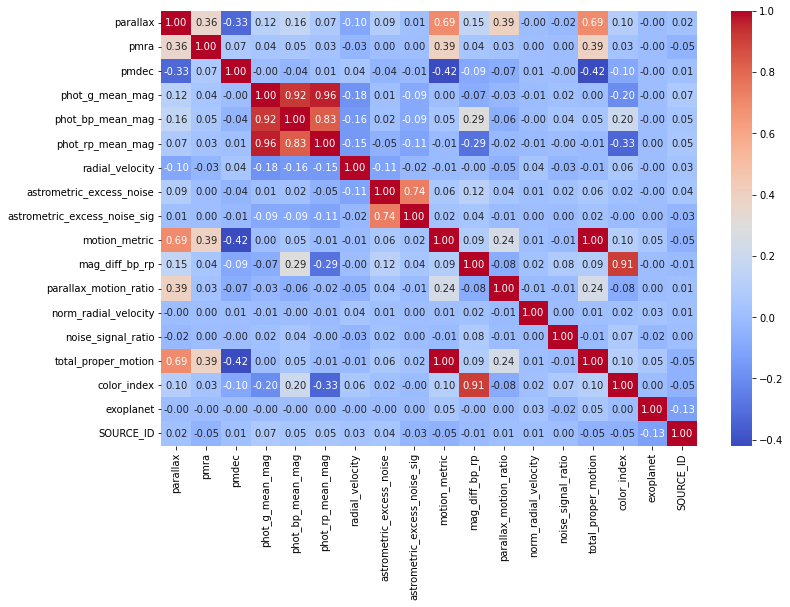

Target distribution before SMOTE: 0    730
1    730
Name: exoplanet, dtype: int64
Target distribution after SMOTE: (array([0, 1], dtype=int64), array([730, 730], dtype=int64))
Shape of X_balanced: (1460, 16)
Shape of y_balanced: (1460,)
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Cross-validated ROC AUC scores: [0.99320622 0.99145299 0.98831093 0.98150604 0.99602122]
Mean ROC AUC score: 0.9900994813439178
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       148
           1       0.97      0.93      0.95       144

    accuracy                           0.95       292
   macro avg       0.95      0.95      0.95       292
weighted avg       0.95      0.95      0.95       292

ROC AUC Score on test set: 0.9944162912912913
Feature importances:
 astrometric_excess_noise_sig    0.400431
noise_signal_ratio              0.165931
color_index                     0.106612
mag_diff_bp_rp                  0.099371
astrometric_exc

In [9]:
# Machine Learning Model Using Candidates

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Function to query GAIA database for astrometric data
def query_gaia_data(query):
    job = Gaia.launch_job(query)
    results = job.get_results()
    return results.to_pandas()

# Query for exoplanet candidates (top 730 entries)
query_candidates = """
SELECT TOP 730 
    source_id AS SOURCE_ID, parallax, pmra, pmdec, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, radial_velocity, 
    astrometric_excess_noise, astrometric_excess_noise_sig
FROM gaiadr3.gaia_source
WHERE parallax IS NOT NULL
AND pmra IS NOT NULL
AND pmdec IS NOT NULL
AND phot_g_mean_mag IS NOT NULL
AND phot_bp_mean_mag IS NOT NULL
AND phot_rp_mean_mag IS NOT NULL
AND radial_velocity IS NOT NULL
AND astrometric_excess_noise IS NOT NULL
AND astrometric_excess_noise_sig IS NOT NULL
"""

# Function to preprocess GAIA data
def preprocess_data(df):
    SOURCE_IDs = df['SOURCE_ID']
    df = df.drop('SOURCE_ID', axis=1)
    
    # Handle missing values
    imputer = SimpleImputer(strategy='median')
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # Standardize the data
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_imputed), columns=df.columns)
    
    df_scaled['SOURCE_ID'] = SOURCE_IDs.values
    return df_scaled

# Query GAIA data for exoplanet candidates
candidates_data = query_gaia_data(query_candidates)
candidates_data = preprocess_data(candidates_data)

# Load the confirmed planets data
confirmed_planets_data = pd.read_csv('gaia_query_results.csv')

# Preprocess confirmed planets data
confirmed_data = preprocess_data(confirmed_planets_data)

# Assign labels
candidates_data['exoplanet'] = 0
confirmed_data['exoplanet'] = 1

# Combine datasets
combined_data = pd.concat([candidates_data, confirmed_data], ignore_index=True)

# Feature engineering
def feature_engineering(df):
    # Create a composite motion metric
    df['motion_metric'] = np.sqrt(df['pmra']**2 + df['pmdec']**2)
    
    # Create a magnitude difference feature
    df['mag_diff_bp_rp'] = df['phot_bp_mean_mag'] - df['phot_rp_mean_mag']
    
    # Create a parallax to motion ratio
    df['parallax_motion_ratio'] = df['parallax'] / df['motion_metric']
    
    # Create a normalized radial velocity feature
    df['norm_radial_velocity'] = df['radial_velocity'] / df['parallax']
    
    # Create a feature for the noise to signal ratio
    df['noise_signal_ratio'] = df['astrometric_excess_noise'] / df['astrometric_excess_noise_sig']
    
    # Create a feature for total proper motion
    df['total_proper_motion'] = np.sqrt(df['pmra']**2 + df['pmdec']**2)
    
    # Create a color index
    df['color_index'] = df['phot_bp_mean_mag'] - df['phot_g_mean_mag']
    
    return df

# Feature engineering
combined_data = feature_engineering(combined_data)

# Filter to include only the specified columns
model_columns = [
    'parallax', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'radial_velocity', 
    'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'motion_metric', 'mag_diff_bp_rp', 
    'parallax_motion_ratio', 'norm_radial_velocity', 'noise_signal_ratio', 'total_proper_motion', 'color_index'
]
combined_data = combined_data[model_columns + ['exoplanet', 'SOURCE_ID']]

# Perform EDA on combined data before splitting
def perform_eda(df):
    # Pairplot for initial visualization
    sns.pairplot(df[['parallax', 'pmra', 'pmdec', 'phot_g_mean_mag', 'motion_metric', 'mag_diff_bp_rp', 'exoplanet']], hue='exoplanet')
    plt.show()

    # Check for correlations
    corr_matrix = df.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.show()

perform_eda(combined_data)

# Split the data into features and target
X = combined_data.drop(['exoplanet', 'SOURCE_ID'], axis=1)
y = combined_data['exoplanet']

# Check the distribution of the target variable
print("Target distribution before SMOTE:", y.value_counts())

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)
print("Target distribution after SMOTE:", np.unique(y_balanced, return_counts=True))

# Check the distribution and shape of the resampled data
print("Shape of X_balanced:", X_balanced.shape)
print("Shape of y_balanced:", y_balanced.shape)

# Split the balanced data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [5000, 6000], # Number of trees in the forest. Increasing this value can improve model performance by reducing variance, but it also increases computational cost.
    'max_depth': [5, 10], # Making trees shallower
    'min_samples_split': [10, 15], # Requiring more samples to split
    'min_samples_leaf': [80, 100] # Requiring more samples at leaf
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='roc_auc')
print("Cross-validated ROC AUC scores:", cv_scores)
print("Mean ROC AUC score:", np.mean(cv_scores))

# Evaluate the model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC Score on test set:", roc_auc_score(y_test, y_pred_proba))

# Check feature importances
feature_importances = pd.Series(best_model.feature_importances_, index=X.columns)
print("Feature importances:\n", feature_importances.sort_values(ascending=False))

# Ensure the dataset used for prediction has the same features as the training set
X_full = combined_data[model_columns]

# Predict probabilities on the entire dataset
combined_data['probability'] = best_model.predict_proba(X_full)[:, 1]

# Sort by the highest probabilities and select the top 10 candidates
# top_candidates = combined_data[combined_data['exoplanet'] == 0].nlargest(10, 'probability')
top_candidates = combined_data.nlargest(10, 'probability')

print("Top 10 Exoplanet Candidates:")
print(top_candidates[['SOURCE_ID', 'probability']])

In [10]:
import seaborn as sns

# Save pairplot as an 8K JPEG with the same scale
pairplot_fig = sns.pairplot(combined_data[['parallax', 'pmra', 'pmdec', 'phot_g_mean_mag', 'motion_metric', 'mag_diff_bp_rp', 'exoplanet']], hue='exoplanet')
pairplot_fig.fig.tight_layout(pad=2.0)  # Adjust padding
pairplot_fig.savefig('pairplot_8k_candidates.jpeg', dpi=800, quality=95, format='jpeg')
plt.close()

# Save heatmap as an 8K JPEG with the same scale
corr_matrix = combined_data.corr()
heatmap_fig, ax = plt.subplots(figsize=(12, 8))  # Keep the same figure size
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', ax=ax)
heatmap_fig.tight_layout(pad=2.0)  # Adjust padding
heatmap_fig.savefig('heatmap_8k_candidates.jpeg', dpi=800, quality=95, format='jpeg')
plt.close()

C:\Users\Fluff\AppData\Local\Temp\ipykernel_9508\2642091092.py:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6
  heatmap_fig.savefig('heatmap_8k_candidates.jpeg', dpi=800, quality=95, format='jpeg')


In [10]:
# Use model on query embeded in code
# Function to query GAIA database for astrometric data
# This one using the test data from False Positives

def query_gaia_data(query):
    job = Gaia.launch_job(query)
    results = job.get_results()
    return results.to_pandas()

# Query to fetch the first 1000 rows
query_first_1000 = """
SELECT TOP 1000 
    source_id AS SOURCE_ID, parallax, pmra, pmdec, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, radial_velocity, 
    astrometric_excess_noise, astrometric_excess_noise_sig
FROM gaiadr3.gaia_source
WHERE parallax IS NOT NULL
AND pmra IS NOT NULL
AND pmdec IS NOT NULL
AND phot_g_mean_mag IS NOT NULL
AND phot_bp_mean_mag IS NOT NULL
AND phot_rp_mean_mag IS NOT NULL
AND radial_velocity IS NOT NULL
AND astrometric_excess_noise IS NOT NULL
AND astrometric_excess_noise_sig IS NOT NULL
ORDER BY source_id
"""

# Fetch the first 1000 rows
first_1000_data = query_gaia_data(query_first_1000)
max_source_id = first_1000_data['SOURCE_ID'].max()

# Query to fetch the next 250,000 rows starting after the maximum source_id from the first 730 rows
query_next_250000 = f"""
SELECT TOP 250000
    source_id AS SOURCE_ID, parallax, pmra, pmdec, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, radial_velocity, 
    astrometric_excess_noise, astrometric_excess_noise_sig
FROM gaiadr3.gaia_source
WHERE source_id > {max_source_id}
AND parallax IS NOT NULL
AND pmra IS NOT NULL
AND pmdec IS NOT NULL
AND phot_g_mean_mag IS NOT NULL
AND phot_bp_mean_mag IS NOT NULL
AND phot_rp_mean_mag IS NOT NULL
AND radial_velocity IS NOT NULL
AND astrometric_excess_noise IS NOT NULL
AND astrometric_excess_noise_sig IS NOT NULL
ORDER BY source_id
"""

# Fetch the next 250,000 rows
next_250000_data = query_gaia_data(query_next_250000)

# Function to preprocess GAIA data
def preprocess_data(df):
    SOURCE_IDs = df['SOURCE_ID']
    df = df.drop('SOURCE_ID', axis=1)
    
    # Handle missing values
    imputer = SimpleImputer(strategy='median')
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # Standardize the data
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_imputed), columns=df.columns)
    
    df_scaled['SOURCE_ID'] = SOURCE_IDs.values
    return df_scaled

# Function to perform feature engineering
def feature_engineering(df):
    # Create a composite motion metric
    df['motion_metric'] = np.sqrt(df['pmra']**2 + df['pmdec']**2)
    
    # Create a magnitude difference feature
    df['mag_diff_bp_rp'] = df['phot_bp_mean_mag'] - df['phot_rp_mean_mag']
    
    # Create a parallax to motion ratio
    df['parallax_motion_ratio'] = df['parallax'] / df['motion_metric']
    
    # Create a normalized radial velocity feature
    df['norm_radial_velocity'] = df['radial_velocity'] / df['parallax']
    
    # Create a feature for the noise to signal ratio
    df['noise_signal_ratio'] = df['astrometric_excess_noise'] / df['astrometric_excess_noise_sig']
    
    # Create a feature for total proper motion
    df['total_proper_motion'] = np.sqrt(df['pmra']**2 + df['pmdec']**2)
    
    # Create a color index
    df['color_index'] = df['phot_bp_mean_mag'] - df['phot_g_mean_mag']
    
    return df

# Preprocess the new data
new_data_preprocessed = preprocess_data(next_250000_data)
new_data_features = feature_engineering(new_data_preprocessed)

# Ensure the dataset used for prediction has the same features as the training set
model_columns = [
    'parallax', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'radial_velocity', 
    'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'motion_metric', 'mag_diff_bp_rp', 
    'parallax_motion_ratio', 'norm_radial_velocity', 'noise_signal_ratio', 'total_proper_motion', 'color_index'
]

X_new = new_data_features[model_columns]

# Load the previously trained model
best_model = grid_search.best_estimator_

# Predict probabilities on the new dataset
next_250000_data['probability'] = best_model.predict_proba(X_new)[:, 1]

# Sort by the highest probabilities and select the top 10 candidates
top_new_candidates = next_250000_data.nlargest(10, 'probability')

print("Top 10 New Exoplanet Candidates:")
print(top_new_candidates[['SOURCE_ID', 'probability']])

# See what these candidates have in common with known exoplanets.
# Anaylze the plots on the single search on Gaia
# 83348929916333568
# 61844475342807680
# Graph RA and DEC proper motion (find 70ish datapoints for each source ID)
# looking for F to K Stars, this might be searching for M stars
    # Use color index
    # Maybe look into M stars for higher proper motion

Top 10 New Exoplanet Candidates:
                SOURCE_ID  probability
36034   30941429732385152     0.967876
41340   34753161667946240     0.967819
3200     3485078198515840     0.967780
86219   59761244404115328     0.967700
73529   53009212219874304     0.967642
85442   59333465661910400     0.967604
5129     5121357659067136     0.967557
126495  81332558733784064     0.967335
110019  70349953697288320     0.967063
115166  72244476655079168     0.967019


In [15]:
# Use model on CSV File obtained from Gaia Archive
# Function to query GAIA database for astrometric data
# This one using the test data from Candidates

def query_gaia_data(query):
    job = Gaia.launch_job(query)
    results = job.get_results()
    return results.to_pandas()

# Read CSV File and Remove first 1000 rows
all_csv_data = pd.read_csv('1722720027931O-result.csv')
csv_data_1000_rows_removed = all_csv_data.iloc[1000:]

# Function to preprocess GAIA data
def preprocess_data(df):
    SOURCE_IDs = df['SOURCE_ID']
    df = df.drop('SOURCE_ID', axis=1)
    
    # Handle missing values
    imputer = SimpleImputer(strategy='median')
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # Standardize the data
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_imputed), columns=df.columns)
    
    df_scaled['SOURCE_ID'] = SOURCE_IDs.values
    return df_scaled

# Function to perform feature engineering
def feature_engineering(df):
    # Create a composite motion metric
    df['motion_metric'] = np.sqrt(df['pmra']**2 + df['pmdec']**2)
    
    # Create a magnitude difference feature
    df['mag_diff_bp_rp'] = df['phot_bp_mean_mag'] - df['phot_rp_mean_mag']
    
    # Create a parallax to motion ratio
    df['parallax_motion_ratio'] = df['parallax'] / df['motion_metric']
    
    # Create a normalized radial velocity feature
    df['norm_radial_velocity'] = df['radial_velocity'] / df['parallax']
    
    # Create a feature for the noise to signal ratio
    df['noise_signal_ratio'] = df['astrometric_excess_noise'] / df['astrometric_excess_noise_sig']
    
    # Create a feature for total proper motion
    df['total_proper_motion'] = np.sqrt(df['pmra']**2 + df['pmdec']**2)
    
    # Create a color index
    df['color_index'] = df['phot_bp_mean_mag'] - df['phot_g_mean_mag']
    
    return df

# Preprocess the new data
new_data_preprocessed = preprocess_data(csv_data_1000_rows_removed)
new_data_features = feature_engineering(new_data_preprocessed)

# Ensure the dataset used for prediction has the same features as the training set
model_columns = [
    'parallax', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'radial_velocity', 
    'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'motion_metric', 'mag_diff_bp_rp', 
    'parallax_motion_ratio', 'norm_radial_velocity', 'noise_signal_ratio', 'total_proper_motion', 'color_index'
]

X_new = new_data_features[model_columns]

# Load the previously trained model
best_model = grid_search.best_estimator_

# Predict probabilities on the new dataset
csv_data_1000_rows_removed['probability'] = best_model.predict_proba(X_new)[:, 1]

# Sort by the highest probabilities and select the top 10 candidates
top_new_candidates = csv_data_1000_rows_removed.nlargest(10, 'probability')

print("Top 10 New Exoplanet Candidates:")
print(top_new_candidates[['SOURCE_ID', 'probability']])

# See what these candidates have in common with known exoplanets.
# Anaylze the plots on the single search on Gaia
# 83348929916333568
# 61844475342807680
# Graph RA and DEC proper motion (find 70ish datapoints for each source ID)
# looking for F to K Stars, this might be searching for M stars
    # Use color index
    # Maybe look into M stars for higher proper motion

Top 10 New Exoplanet Candidates:
                 SOURCE_ID  probability
90806    61844475342807680     0.721739
572040  207718156172924544     0.720499
191820  121307472921167872     0.718014
622948  216361726315559936     0.717782
498422  197800703024894080     0.717729
924750  274021937141777152     0.717698
291919  157534319474032384     0.717443
989744  287524283528250752     0.717251
793270  250982529976020352     0.716088
468300  193425501444894592     0.716076


C:\Users\Fluff\AppData\Local\Temp\ipykernel_8184\598582125.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csv_data_1000_rows_removed['probability'] = best_model.predict_proba(X_new)[:, 1]


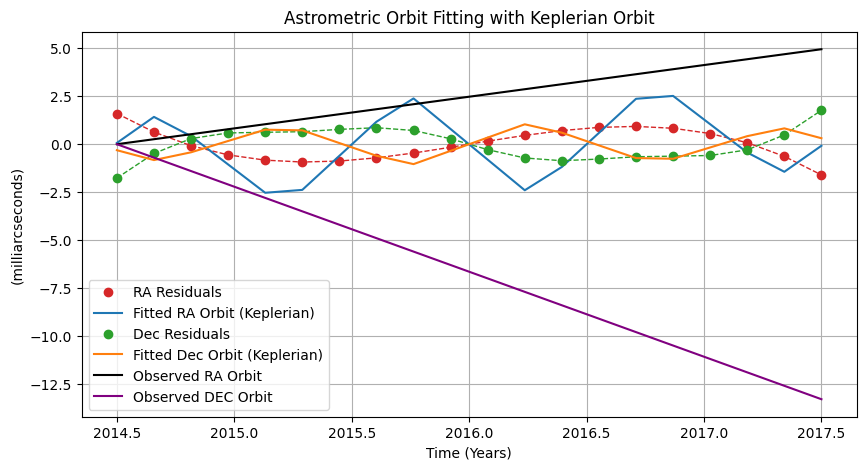

Improved Fitted Parameters for RA: [ 4.13082714e+00  6.01058865e-01  5.10100651e-01  1.61424220e+00
  3.09401228e+00  1.16268935e+00  2.01425622e+03 -6.02210132e-03]
Improved Fitted Parameters for Dec: [8.06621875e-02 1.94021894e-03 2.59771975e+00 5.09354580e+00
 2.43053767e-01 3.18829327e-01 2.01173664e+03 1.07184837e+00]


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia
from astropy.time import Time
from scipy.optimize import curve_fit
%matplotlib inline

# Source ID for the candidate
source_id = '53009212219874304'

def get_gaia_data(source_id):
    """
    Query Gaia data for a given source ID.
    """
    query = f"""
    SELECT ra, dec, parallax, pmra, pmdec, radial_velocity, ref_epoch
    FROM gaiadr3.gaia_source
    WHERE source_id = {source_id}
    """
    job = Gaia.launch_job(query)
    result = job.get_results()
    return result[0]

def compute_position(ra, dec, pmra, pmdec, ref_epoch, epochs):
    """
    Compute observed RA and Dec positions based on proper motion.
    """
    ra_rad = np.deg2rad(ra)
    dec_rad = np.deg2rad(dec)
    pmra_rad = np.deg2rad(pmra / 3600)
    pmdec_rad = np.deg2rad(pmdec / 3600)

    positions = []
    for epoch in epochs:
        delta_t = epoch - ref_epoch
        ra_new = ra_rad + pmra_rad * delta_t
        dec_new = dec_rad + pmdec_rad * delta_t
        positions.append((np.rad2deg(ra_new), np.rad2deg(dec_new)))
    return positions

# Get Gaia data for the source
gaia_data = get_gaia_data(source_id)

# Extract data for further analysis
ra = gaia_data['ra']
dec = gaia_data['dec']
pmra = gaia_data['pmra']
pmdec = gaia_data['pmdec']
parallax = gaia_data['parallax']
ref_epoch = gaia_data['ref_epoch']

# Define the observation epochs (e.g., from 2014.5 to 2017.5)
epochs = np.linspace(2014.5, 2017.5, 20)

# Compute observed RA and Dec positions
observed_positions = compute_position(ra, dec, pmra, pmdec, ref_epoch, epochs)

# Extract RA and Dec for the observed positions
observed_ra, observed_dec = zip(*observed_positions)

# Convert observed positions to milliarcseconds for consistency
observed_ra = np.array(observed_ra) * 1000
observed_dec = np.array(observed_dec) * 1000

# Original time range for fitting (±5 years around ref_epoch)
time_years_full = np.linspace(ref_epoch - 5, ref_epoch + 5, 20)  # Full time range for the model

# Calculate predicted RA and Dec based on proper motion (over full time range)
predicted_ra_full = observed_ra + pmra * (time_years_full - ref_epoch)
predicted_dec_full = observed_dec + pmdec * (time_years_full - ref_epoch)

# Calculate residuals (over full time range)
ra_residuals_full = observed_ra - predicted_ra_full
dec_residuals_full = observed_dec - predicted_dec_full

# Query Gaia Archive for the astrometric data of the given source ID
job = Gaia.launch_job(f"""
SELECT
    ra, dec, ref_epoch, pmra, pmdec, parallax
FROM gaiadr3.gaia_source
WHERE source_id = {source_id}
""")
result = job.get_results()

# Extract data from the query result
ra_data = result['ra'].data[0] * 1000  # Convert to milliarcseconds
dec_data = result['dec'].data[0] * 1000  # Convert to milliarcseconds
ref_epoch = result['ref_epoch'].data[0]
pmra = result['pmra'].data[0]
pmdec = result['pmdec'].data[0]
parallax = result['parallax'].data[0]

# Time range for fitting (scaled to the desired time range 2014.5-2017.5)
time_years_scaled = np.linspace(2014.5, 2017.5, 20)

# Calculate predicted RA and Dec based on proper motion
predicted_ra_full = ra_data + pmra * (time_years_scaled - ref_epoch)
predicted_dec_full = dec_data + pmdec * (time_years_scaled - ref_epoch)

# Define a full Keplerian orbital model including parallax
def keplerian_orbit(t, a, e, i, omega, Omega, P, T0, parallax):
    """
    Full Keplerian model for astrometric orbit including parallax.
    
    t: time in years
    a: semi-major axis (milliarcseconds)
    e: eccentricity
    i: inclination (radians)
    omega: argument of periapsis (radians)
    Omega: longitude of ascending node (radians)
    P: orbital period (years)
    T0: time of periapsis passage (years)
    parallax: parallax (milliarcseconds)
    
    Returns:
    ra_total, dec_total: RA and Dec offsets (milliarcseconds)
    """
    # Mean anomaly
    M = 2 * np.pi * (t - T0) / P
    
    # Eccentric anomaly using Newton's method
    E = M  # Initial guess for eccentric anomaly
    for _ in range(10):
        E = M + e * np.sin(E)
    
    # True anomaly
    nu = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E / 2), np.sqrt(1 - e) * np.cos(E / 2))
    
    # Orbital positions in the orbital plane
    r = a * (1 - e * np.cos(E))
    x_orbit = r * np.cos(nu)
    y_orbit = r * np.sin(nu)
    
    # Convert to sky coordinates
    x_sky = x_orbit * (np.cos(omega) * np.cos(Omega) - np.sin(omega) * np.sin(Omega) * np.cos(i)) \
          - y_orbit * (np.sin(omega) * np.cos(Omega) + np.cos(omega) * np.sin(Omega) * np.cos(i))
    y_sky = x_orbit * (np.cos(omega) * np.sin(Omega) + np.sin(omega) * np.cos(Omega) * np.cos(i)) \
          + y_orbit * (np.cos(omega) * np.sin(Omega) * np.cos(i) - np.sin(omega) * np.cos(Omega))
    
    # Include parallax
    parallax_ra = parallax * np.cos(2 * np.pi * t)
    parallax_dec = parallax * np.sin(2 * np.pi * t)
    
    # Total RA and Dec offsets
    ra_total = x_sky + parallax_ra
    dec_total = y_sky + parallax_dec
    
    return ra_total, dec_total

# Use the same function for both RA and Dec fitting
def fit_function_ra(t, a, e, i, omega, Omega, P, T0, parallax):
    ra, _ = keplerian_orbit(t, a, e, i, omega, Omega, P, T0, parallax)
    return ra

def fit_function_dec(t, a, e, i, omega, Omega, P, T0, parallax):
    _, dec = keplerian_orbit(t, a, e, i, omega, Omega, P, T0, parallax)
    return dec

# Improved initial guess parameters
initial_params = [0.01, 0.1, np.radians(30), np.radians(45), np.radians(60), 1.0, ref_epoch, parallax]

# Define bounds for the parameters to help guide the optimizer
bounds = ([0, 0, 0, 0, 0, 0.1, ref_epoch - 5, parallax - 5], 
          [np.inf, 1, np.pi, 2*np.pi, 2*np.pi, 10, ref_epoch + 5, parallax + 5])

# Fit the RA and Dec residuals using bounded optimization
popt_ra, _ = curve_fit(fit_function_ra, time_years_scaled, ra_residuals_full, p0=initial_params, bounds=bounds, maxfev=20000)
popt_dec, _ = curve_fit(fit_function_dec, time_years_scaled, dec_residuals_full, p0=initial_params, bounds=bounds, maxfev=20000)

# Predict the RA and Dec values based on the fit
fitted_ra_scaled = fit_function_ra(time_years_scaled, *popt_ra)
fitted_dec_scaled = fit_function_dec(time_years_scaled, *popt_dec)

# Calculate residuals after fitting
ra_residuals_fit = ra_residuals_full - fitted_ra_scaled
dec_residuals_fit = dec_residuals_full - fitted_dec_scaled

# Original time range for fitting (±5 years around ref_epoch)
time_years_full = np.linspace(ref_epoch - 5, ref_epoch + 5, 20)  # Full time range for the model

# Calculate predicted RA and Dec based on proper motion (over full time range)
predicted_ra_full = ra_data + pmra * (time_years_full - ref_epoch)
predicted_dec_full = dec_data + pmdec * (time_years_full - ref_epoch)

# Calculate residuals (over full time range)
ra_residuals_full = ra_data - predicted_ra_full
dec_residuals_full = dec_data - predicted_dec_full

# Define a full Keplerian orbital model including parallax
def keplerian_orbit(t, a, e, i, omega, Omega, P, T0, parallax):
    """
    Full Keplerian model for astrometric orbit including parallax.
    
    t: time in years
    a: semi-major axis (milliarcseconds)
    e: eccentricity
    i: inclination (radians)
    omega: argument of periapsis (radians)
    Omega: longitude of ascending node (radians)
    P: orbital period (years)
    T0: time of periapsis passage (years)
    parallax: parallax (milliarcseconds)
    
    Returns:
    ra_total, dec_total: RA and Dec offsets (milliarcseconds)
    """
    # Mean anomaly
    M = 2 * np.pi * (t - T0) / P
    
    # Eccentric anomaly using Newton's method
    E = M  # Initial guess for eccentric anomaly
    for _ in range(10):
        E = M + e * np.sin(E)
    
    # True anomaly
    nu = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E / 2), np.sqrt(1 - e) * np.cos(E / 2))
    
    # Orbital positions in the orbital plane
    r = a * (1 - e * np.cos(E))
    x_orbit = r * np.cos(nu)
    y_orbit = r * np.sin(nu)
    
    # Convert to sky coordinates
    x_sky = x_orbit * (np.cos(omega) * np.cos(Omega) - np.sin(omega) * np.sin(Omega) * np.cos(i)) \
          - y_orbit * (np.sin(omega) * np.cos(Omega) + np.cos(omega) * np.sin(Omega) * np.cos(i))
    y_sky = x_orbit * (np.cos(omega) * np.sin(Omega) + np.sin(omega) * np.cos(Omega) * np.cos(i)) \
          + y_orbit * (np.cos(omega) * np.sin(Omega) * np.cos(i) - np.sin(omega) * np.cos(Omega))
    
    # Include parallax
    parallax_ra = parallax * np.cos(2 * np.pi * t)
    parallax_dec = parallax * np.sin(2 * np.pi * t)
    
    # Total RA and Dec offsets
    ra_total = x_sky + parallax_ra
    dec_total = y_sky + parallax_dec
    
    return ra_total, dec_total

# Use the same function for both RA and Dec fitting
def fit_function_ra(t, a, e, i, omega, Omega, P, T0, parallax):
    ra, _ = keplerian_orbit(t, a, e, i, omega, Omega, P, T0, parallax)
    return ra

def fit_function_dec(t, a, e, i, omega, Omega, P, T0, parallax):
    _, dec = keplerian_orbit(t, a, e, i, omega, Omega, P, T0, parallax)
    return dec

# Initial guess parameters for the fit
initial_params = [0.01, 0.1, np.radians(30), np.radians(45), np.radians(60), 1.0, ref_epoch, parallax]

# Define bounds for the parameters to help guide the optimizer
bounds = ([0, 0, 0, 0, 0, 0.1, ref_epoch - 5, parallax - 5], 
          [np.inf, 1, np.pi, 2*np.pi, 2*np.pi, 10, ref_epoch + 5, parallax + 5])

# Fit the RA and Dec residuals using bounded optimization (over full time range)
popt_ra, _ = curve_fit(fit_function_ra, time_years_full, ra_residuals_full, p0=initial_params, bounds=bounds, maxfev=20000)
popt_dec, _ = curve_fit(fit_function_dec, time_years_full, dec_residuals_full, p0=initial_params, bounds=bounds, maxfev=20000)

# Predict the RA and Dec values based on the fit (over full time range)
fitted_ra_full = fit_function_ra(time_years_full, *popt_ra)
fitted_dec_full = fit_function_dec(time_years_full, *popt_dec)

# Now, scale the results to the desired time range (2014.5-2017.5)
time_years_scaled = np.linspace(2014.5, 2017.5, 20)

# Interpolate the fitted results to match the scaled time range
fitted_ra_scaled = np.interp(time_years_scaled, time_years_full, fitted_ra_full)
fitted_dec_scaled = np.interp(time_years_scaled, time_years_full, fitted_dec_full)

dpi_8k = 768  # for a 10x5 inch figure to reach 7680x4320 pixels

observed_ra_relative = observed_ra - observed_ra[0]
observed_dec_relative = observed_dec - observed_dec[0]

# Plot: Fitted Model with Keplerian Orbit and Parallax Effects (Scaled)
plt.figure(figsize=(10, 5))
plt.plot(time_years_scaled, ra_residuals_fit, 'o', color='tab:red', label='RA Residuals')
plt.plot(time_years_scaled, ra_residuals_fit, '--', linewidth=1, color='tab:red')  # Dotted line for RA residuals
plt.plot(time_years_scaled, fitted_ra_scaled, '-', label='Fitted RA Orbit (Keplerian)', color='tab:blue')
plt.plot(time_years_scaled, dec_residuals_fit, 'o', color='tab:green', label='Dec Residuals')
plt.plot(time_years_scaled, dec_residuals_fit, '--', linewidth=1, color='tab:green')  # Dotted line for Dec residuals
plt.plot(time_years_scaled, fitted_dec_scaled, '-', label='Fitted Dec Orbit (Keplerian)', color='tab:orange')
plt.plot(time_years_scaled, observed_ra_relative, '-', label='Observed RA Orbit', color='black') # Plot Scaled Observed RA Data
plt.plot(time_years_scaled, observed_dec_relative, '-', label='Observed DEC Orbit', color='purple') # Plot Scaled Observed DEC Data
plt.xlabel('Time (Years)')
plt.ylabel('(milliarcseconds)')
plt.title('Astrometric Orbit Fitting with Keplerian Orbit')
plt.legend()
plt.grid(True)
plt.savefig('astrometric_orbit_fitting_random_candidate.jpeg', format='jpeg', dpi=dpi_8k)  # Saves Figure as JPEG
plt.show()

# Display the fitted parameters
print("Improved Fitted Parameters for RA:", popt_ra)
print("Improved Fitted Parameters for Dec:", popt_dec)